### Face detection and feature extraction

#### First we train a custom age classifier

In [1]:
import urllib
import os
import shutil
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from tensorflow.keras.models import model_from_json
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

2022-06-22 01:14:50.756657: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
data_DIR = 'Data/Age_cls/Age_DATA/'

traindf = pd.read_csv('Data/Age_cls/Age_data.csv').iloc()[:,1:3]
traindf.head()

,filename,age
0,95_1.jpg,95
1,95_2.jpg,95
2,95_3.jpg,95
3,53_1.jpg,53
4,53_2.jpg,53


In [3]:
# Some ages are severely underrepresented - switching to buckets 
# Create buckets for age
bins = [0, 18, 26, 39, 60, np.inf]
names = ['1-18', '19-26', '27-39', '40-60', '60+']

traindf['age'] = pd.cut(traindf['age'].astype('float'), bins, labels=names)
traindf['code'] = traindf['age'].astype('category').cat.codes
filenames = [file for file in os.listdir(data_DIR)]
traindf = traindf[traindf.filename.isin(filenames)].reset_index(drop=True)
print(len(traindf.age.unique()), traindf.shape)
traindf.head()

5 (34426, 3)


,filename,age,code
0,95_1.jpg,60+,4
1,95_2.jpg,60+,4
2,95_3.jpg,60+,4
3,53_1.jpg,40-60,3
4,53_2.jpg,40-60,3


In [4]:
df = traindf.groupby(['age', 'code']).count()
df = df[df.filename > 0]
df

,,filename
age,code,
1-18,0,8920
19-26,1,6792
27-39,2,8274
40-60,3,6712
60+,4,3728


In [5]:
def printHistory(history, filename):
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.suptitle('VGG-19')
    
    
    ax1.set_title('Accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'val'], loc='upper left')
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    
    ax2.set_title('Loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'val'], loc='upper left')
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])

    plt.savefig(filename)

    plt.show()

In [6]:
# The model is build on VGG-face

def createModel():
    import coral_ordinal as coral

    #VGG-Face model
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Convolution2D(101, (1, 1), name='predictions'))
    model.add(Flatten())
    model.add(Activation('softmax'))
    
    
    model.load_weights('models/pre_trained//age_model_weights.h5')

    # Now lets try finetuning the deepface model that already has the wiki data
    
    for layer in model.layers[:-7]:
        layer.trainable = False

    base_model_output = Sequential()
    base_model_output = Dropout(0.5)(model.layers[-4].output)
    # base_model_output = Flatten()(base_model_output)
    # base_model_output = coral.CoralOrdinal(8)(base_model_output)
    base_model_output = Convolution2D(5, (1, 1), name='predictions')(base_model_output)
    base_model_output = Flatten()(base_model_output)
    base_model_output = Activation('softmax')(base_model_output)   

    age_model = Model(inputs=model.input, outputs=base_model_output)

    # age_model.summary()

    age_model.compile(loss = "categorical_crossentropy",
              optimizer = optimizers.Adadelta(lr = 1.0, rho = 0.95, epsilon = 1e-08, decay = 0.0),
              metrics = ['accuracy'])


    ## Did not improve accuracy
    # age_model.compile(loss = coral.OrdinalCrossEntropy(8),
    #           metrics = [coral.MeanAbsoluteErrorLabels()],
    #           optimizer = optimizers.Adadelta(lr = 1.0, rho = 0.95, epsilon = 1e-08, decay = 0.0))
    
    return age_model

In [7]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(traindf, test_size=0.2, random_state=1411)

2022-06-22 01:15:17.447009: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-22 01:15:17.448552: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-06-22 01:15:17.462289: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:86:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-06-22 01:15:17.462315: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-06-22 01:15:17.464679: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-06-22 01:15:17.464724: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.

Found 27540 validated image filenames belonging to 5 classes.
Found 6886 validated image filenames belonging to 5 classes.


/home/3049637/.conda/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-06-22 01:15:20.734236: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-22 01:15:20.734774: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2100000000 Hz


Epoch 1/100


2022-06-22 01:15:21.915466: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-06-22 01:15:23.366296: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-06-22 01:15:23.482056: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-06-22 01:15:24.781150: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


215/215 [==============================] - 184s 740ms/step - loss: 1.4760 - accuracy: 0.3169 - val_loss: 1.0602 - val_accuracy: 0.5727


2022-06-22 01:18:24.505046: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 411041792 exceeds 10% of free system memory.


Epoch 2/100
215/215 [==============================] - 128s 594ms/step - loss: 1.1714 - accuracy: 0.4843 - val_loss: 0.9406 - val_accuracy: 0.6216


2022-06-22 01:20:33.483346: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 411041792 exceeds 10% of free system memory.


Epoch 3/100
215/215 [==============================] - 125s 580ms/step - loss: 1.0704 - accuracy: 0.5245 - val_loss: 0.8840 - val_accuracy: 0.6344


2022-06-22 01:22:39.389958: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 411041792 exceeds 10% of free system memory.


Epoch 4/100
215/215 [==============================] - 125s 580ms/step - loss: 1.0011 - accuracy: 0.5589 - val_loss: 0.8542 - val_accuracy: 0.6390


2022-06-22 01:24:45.355317: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 411041792 exceeds 10% of free system memory.


Epoch 5/100
215/215 [==============================] - 124s 578ms/step - loss: 0.9635 - accuracy: 0.5783 - val_loss: 0.8199 - val_accuracy: 0.6580
Epoch 6/100
215/215 [==============================] - 125s 582ms/step - loss: 0.9339 - accuracy: 0.5928 - val_loss: 0.8103 - val_accuracy: 0.6598
Epoch 7/100
215/215 [==============================] - 125s 580ms/step - loss: 0.9046 - accuracy: 0.6077 - val_loss: 0.7941 - val_accuracy: 0.6750
Epoch 8/100
215/215 [==============================] - 124s 577ms/step - loss: 0.8884 - accuracy: 0.6133 - val_loss: 0.7852 - val_accuracy: 0.6697
Epoch 9/100
215/215 [==============================] - 125s 578ms/step - loss: 0.8770 - accuracy: 0.6220 - val_loss: 0.7665 - val_accuracy: 0.6809
Epoch 10/100
215/215 [==============================] - 125s 580ms/step - loss: 0.8328 - accuracy: 0.6386 - val_loss: 0.7549 - val_accuracy: 0.6807
Epoch 11/100
215/215 [==============================] - 125s 581ms/step - loss: 0.8241 - accuracy: 0.6408 - val_loss:

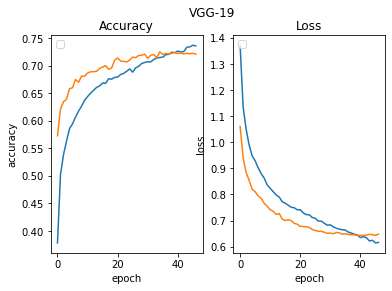

In [8]:
# This one is 7224
import imgaug as ia
import imgaug.augmenters as iaa

ia.seed(1411)

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    # Small gaussian blur with random sigma between 0 and 1.0.
    # But we only blur about 25% of all images.
    iaa.Sometimes(
        0.30,
        iaa.GaussianBlur(sigma=(0, 1.5))
    ),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Sometimes(
      0.30, 
      iaa.Affine(rotate=(-45, 45))
    )
], random_order=True) # apply augmenters in random order


datagen_train = ImageDataGenerator(rescale=1./255.,
      preprocessing_function=seq.augment_image
   )

datagen_valid = ImageDataGenerator(rescale=1./255)

model = createModel()

train_generator = datagen_train.flow_from_dataframe(dataframe=train,
                                          directory=data_DIR,
                                          x_col="filename",
                                          y_col="age",
                                          batch_size=128,
                                          seed=420,
                                          color_mode="rgb",
                                          shuffle=True,
                                          class_mode="categorical",
                                          target_size=(224, 224)
                                          # , validate_filenames=False
                                          );

valid_generator=datagen_valid.flow_from_dataframe(dataframe=test,
                                          directory=data_DIR,
                                          x_col="filename",
                                          y_col="age",
                                          batch_size=128,
                                          seed=420,
                                          color_mode="rgb",
                                          shuffle=False,
                                          class_mode="categorical",
                                          target_size=(224, 224)
                                          # , validate_filenames=False
                                          );

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size


es = history = EarlyStopping(verbose=1, patience=7, restore_best_weights=True)
# EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#Trains the model on data generated batch-by-batch by a Python generator
history = model.fit_generator(generator=train_generator,\
                    validation_data = valid_generator, \
                    steps_per_epoch=STEP_SIZE_TRAIN, \
                    validation_steps=STEP_SIZE_VALID, \
                    epochs=100, \
                    verbose=1, \
                    callbacks=[es])

printHistory(history, 'output/Age_cls_baseline_40b_40d.jpg')
model.save("models/age_cls.h5")

In [13]:
# get predict prob and label 
ypred = model.predict_generator(valid_generator)

/home/3049637/.conda/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
2022-06-21 11:22:30.224846: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.45GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-06-21 11:22:30.632108: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.45GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-06-21 11:22:31.042979: W tensorflow/core/common_runtime/bfc_alloc

In [14]:
y_true = valid_generator.classes
ypred = np.argmax(ypred, axis=1)

In [17]:
# # mapping to 5 categories
# dct = {0:0,1:0,2:1,3:2,4:2,5:3,6:3,7:4}

# y_true_5 = [dct[k] for k in y_true]
# y_pred_5 = [dct[k] for k in ypred]

In [15]:
print('Classification Report')
print(classification_report(y_true, ypred))

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      1786
           1       0.61      0.69      0.65      1366
           2       0.59      0.55      0.57      1655
           3       0.66      0.67      0.67      1333
           4       0.82      0.71      0.76       746

    accuracy                           0.72      6886
   macro avg       0.72      0.71      0.72      6886
weighted avg       0.72      0.72      0.72      6886



Confusion Matrix
[[1652  103   23    6    2]
 [  74  949  318   24    1]
 [  30  469  916  236    4]
 [   5   34  287  894  113]
 [   5    9   11  190  531]]


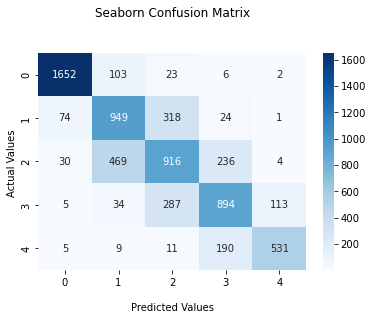

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

print('Confusion Matrix')
cf_matrix = confusion_matrix(y_true, ypred)
print(cf_matrix)

import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_title('Seaborn Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

plt.savefig('output/age_cls_confusion_M')

## Display the visualization of the Confusion Matrix.
plt.show()

In [19]:
# Here is the model before finetuning 
def createModel_old():
    #VGG-Face model
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Convolution2D(101, (1, 1), name='predictions'))
    model.add(Flatten())
    model.add(Activation('softmax'))
    
    
    model.load_weights('models/pre_trained//age_model_weights.h5')

    return model

old_model = createModel_old()

ypred_ = old_model.predict_generator(valid_generator)

/home/3049637/.conda/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [23]:
# This is the methodology used in the original paper
output_indexes = np.array([i for i in range(0, 101)])
apparent_predictions = np.sum(ypred_ * output_indexes, axis = 1)

# Now lets convert to our labels
predicted = np.digitize(apparent_predictions, bins)
predicted

array([3, 4, 3, ..., 3, 3, 2])

In [26]:
predicted -= 1
np.unique(predicted)

array([0, 1, 2, 3, 4])

In [28]:
print('Classification Report')
print(classification_report(y_true, predicted))

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      1786
           1       0.24      0.35      0.29      1366
           2       0.28      0.69      0.39      1655
           3       0.35      0.20      0.26      1333
           4       1.00      0.01      0.02       746

    accuracy                           0.28      6886
   macro avg       0.57      0.25      0.19      6886
weighted avg       0.55      0.28      0.20      6886



Confusion Matrix
[[   2  836  919   29    0]
 [   0  476  880   10    0]
 [   0  465 1141   49    0]
 [   0  146  917  270    0]
 [   0   34  292  413    7]]


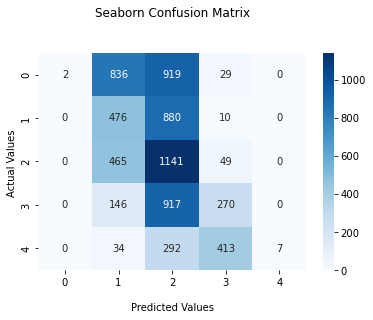

In [29]:
from sklearn.metrics import classification_report, confusion_matrix

print('Confusion Matrix')
cf_matrix = confusion_matrix(y_true, predicted)
print(cf_matrix)

import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_title('Seaborn Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

plt.savefig('output/age_cls_old')

## Display the visualization of the Confusion Matrix.
plt.show()

In [12]:
## Baseine acuracy of 0.6145
## Lets evaluate CORAL results
import coral_ordinal as coral

# Note that these are ordinal (cumulative) logits, not probabilities or regular logits.
ordinal_logits = model.predict(valid_generator)

# Convert from logits to label probabilities. This is initially a tensorflow tensor.
tensor_probs = coral.ordinal_softmax(ordinal_logits)

# Convert the tensor into a pandas dataframe.
probs_df = pd.DataFrame(tensor_probs.numpy())

probs_df.head()

,0,1,2,3,4,5,6,7
0,0.101720,0.485755,0.366887,0.029853,0.012966,0.002236,0.000512,0.000071
1,0.000005,0.000061,0.000899,0.001907,0.013208,0.057267,0.320264,0.606389
2,0.000246,0.002837,0.040357,0.075818,0.315210,0.353707,0.180093,0.031732
3,0.000018,0.000210,0.003117,0.006565,0.043830,0.161988,0.477123,0.307148
4,0.000207,0.002395,0.034297,0.065626,0.290731,0.365150,0.204201,0.037392


In [23]:
ypred = probs_df.idxmax(axis = 1).values
y_true = valid_generator.labels

ypred

array([1, 7, 5, ..., 6, 4, 5])

In [24]:
print('Classification Report')
# target_names = traindf.age.unique()
print(classification_report(y_true, ypred))

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      1190
           1       0.71      0.51      0.59       596
           2       0.54      0.80      0.64      1366
           3       0.00      0.00      0.00       703
           4       0.40      0.56      0.47       952
           5       0.40      0.31      0.35       661
           6       0.52      0.46      0.49       672
           7       0.77      0.78      0.77       746

    accuracy                           0.60      6886
   macro avg       0.53      0.54      0.53      6886
weighted avg       0.55      0.60      0.57      6886



/home/3049637/.conda/envs/tf-gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/3049637/.conda/envs/tf-gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/3049637/.conda/envs/tf-gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix
[[1102   63   17    0    6    1    1    0]
 [ 114  305  163    0   12    2    0    0]
 [   4   46 1095    0  198   18    5    0]
 [   2    8  427    0  242   21    3    0]
 [   0    5  268    0  536  111   28    4]
 [   0    2   41    0  262  203  135   18]
 [   0    1   16    0   62  127  312  154]
 [   0    0    9    0   12   24  121  580]]


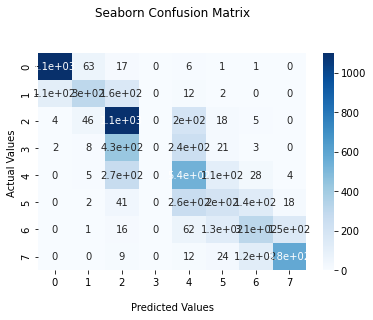

In [25]:
from sklearn.metrics import classification_report, confusion_matrix

print('Confusion Matrix')
cf_matrix = confusion_matrix(y_true, ypred)
print(cf_matrix)

import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');


## Display the visualization of the Confusion Matrix.
plt.show()